In [1]:
import numpy as np
import matplotlib.pyplot as plt

from argosim.antenna_utils import *
from argosim.plot_utils import *
from argosim.data_utils import *
from argosim.clean import *
from argosim.imaging_utils import *
from argosim.beam_utils import *

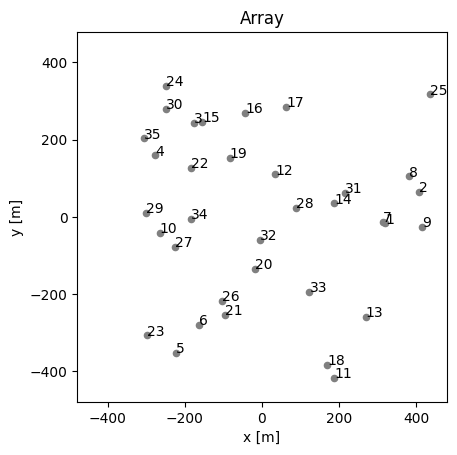

In [3]:
# antenna = load_antenna_enu_txt('../configs/arrays/argos_pathfinder.enu.txt')
antenna = random_antenna_arr(35, E_lim=800, N_lim=800)
plot_antenna_arr(antenna)

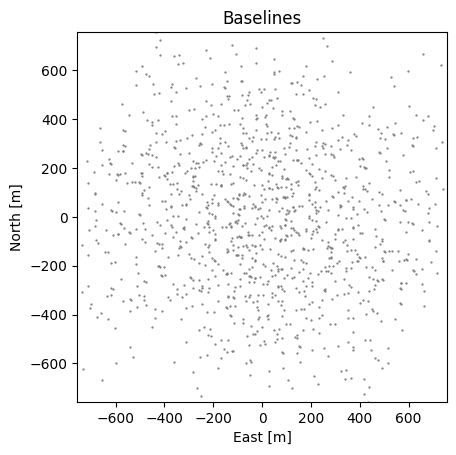

In [4]:
baselines = get_baselines(antenna)
plot_baselines(baselines, ENU=True)

In [8]:
# Multiband parameters
bandwidth = 2000e6
n_freqs = 128
f = 2000e6 # 2 GHz, lambda = 0.15 m

# Source tracking parameters
source_decl = 90./180*np.pi
array_lat = 35./180*np.pi # Heraklion latitud
track_time = 1
delta_t = 15/60 # 300 segs
t_0 = -0.5
n_times = int(track_time/delta_t)

track, freqs = uv_track_multiband(baselines, array_lat, source_decl, track_time, t_0, n_times, f, bandwidth, n_freqs, multi_band=True)

print('The tracking is done for {} frequency bands'.format(n_freqs))
print('UV-samples shape:', track.shape)


The tracking is done for 128 frequency bands
UV-samples shape: (128, 4760, 3)


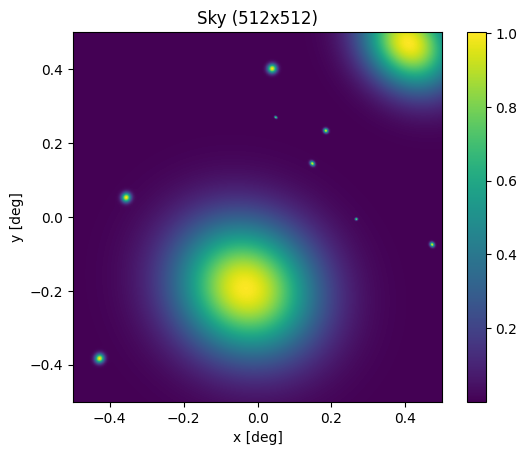

In [44]:
Npx = 512
fov_size = 1. # max 3 degrees FOV from 6 m parabolic dishes.
deg_size_list = np.array([.3, .2, .02, .02, .02, .01, .01, .01, .005, .005])
source_intensity_list = [1]*len(deg_size_list)
sky = n_source_sky((Npx, Npx), fov_size, deg_size_list, source_intensity_list, seed=39807)
plot_sky(sky, (fov_size, fov_size))

# Multi-band observation

In [45]:
primary_beam = CosCubeBeam(c=0.2, f=1., n_pix=Npx, fov_deg=fov_size)
observations, dirty_beams = simulate_dirty_observation(sky, track, fov_size, multi_band=True, freqs=freqs, beam=primary_beam, sigma=0.2)

(128, 512, 512)


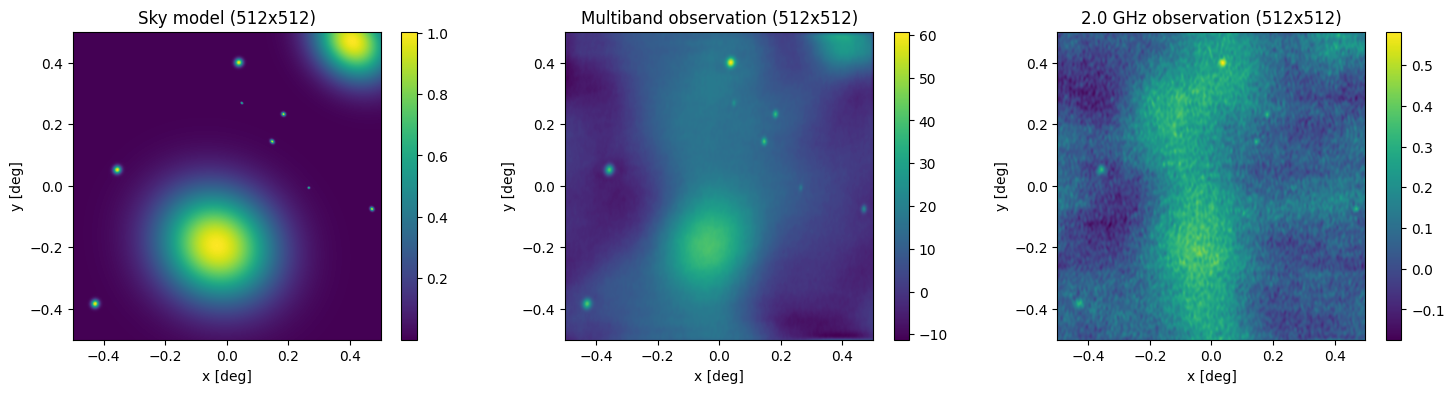

In [47]:
print(observations.shape)

# Plot clean observation
fig, ax = plt.subplots(1, 3, figsize=(18,4))
plot_sky(sky, (fov_size, fov_size), ax[0], fig, 'Sky model')
plot_sky(np.sum(observations, axis=0), (fov_size, fov_size), ax[1], fig, 'Multiband observation')
idx = n_freqs//2
plot_sky(observations[idx], (fov_size, fov_size), ax[2], fig, '{:.1f} GHz observation'.format(freqs[idx]/1e9))
plt.show()

# Single band observation

In [50]:
track_single_b, f_single = uv_track_multiband(baselines, array_lat, source_decl, track_time, t_0, n_times, f, bandwidth, n_freqs, multi_band=False)
observation_single, dirty_beam_single = simulate_dirty_observation(sky, track_single_b, fov_size, multi_band=False, sigma=0.1)

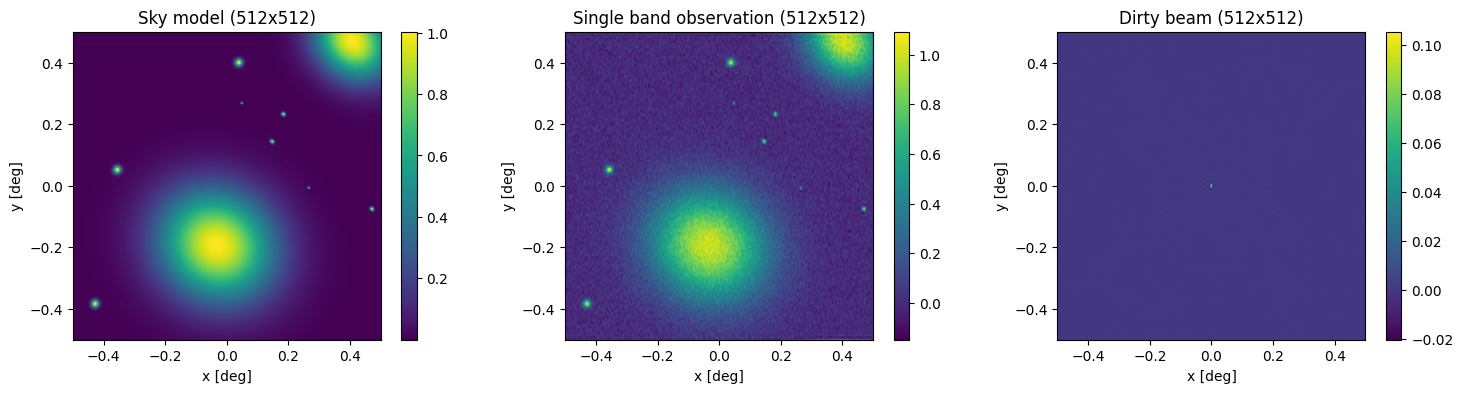

In [51]:
# Plot clean observation
fig, ax = plt.subplots(1, 3, figsize=(18,4))
plot_sky(sky, (fov_size, fov_size), ax[0], fig, 'Sky model')
plot_sky(observation_single, (fov_size, fov_size), ax[1], fig, 'Single band observation')
idx = 1
plot_sky(dirty_beam_single, (fov_size, fov_size), ax[2], fig, 'Dirty beam')
plt.show()